<a href="https://colab.research.google.com/github/janwaelty/artwork_valuation/blob/main/data_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#Neural Networks and the Art Market: A Deep Learning Approach to Valuation
#   **Numerical-features-only model**

**1. Library and data import**

In [37]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
import re
import torch
import torch.nn as nn



drive.mount('/content/drive')
artist_data_path= "/content/drive/My Drive/artist_graph_data.xlsx"
artwork_numeric_data = pd.read_excel(artist_data_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**2. Data preprocessing**

In [38]:
def repeated_to_single_transactions(df):
    """
    Transforms a dataset by splitting purchase and sale data into separate rows
    and renaming columns for consistency.
    """
    # Columns to keep (common info)
    common_columns = ['category', 'artist', 'height', 'width', 'medium']

    # Sale Data: Keep only relevant columns
    sale_data = df[common_columns + ['sale_year_semi', 'sale_price',
                                     'sale_house']].copy()
    sale_data = sale_data.rename(columns={
        'sale_year_semi': 'transaction_year_semi',
        'sale_price': 'transaction_price',
        'sale_house': 'transaction_house'
    })


    # Purchase Data: Keep only relevant columns
    purchase_data = df[common_columns + ['purchase_year_semi', 'purchase_price',
                                         'purchase_house']].copy()
    purchase_data = purchase_data.rename(columns={
        'purchase_year_semi': 'transaction_year_semi',
        'purchase_price': 'transaction_price',
        'purchase_house': 'transaction_house'
    })

    final_df = pd.concat([sale_data, purchase_data], ignore_index=True)

    return final_df


def one_hot(data, vars):
  # one-hot encoding for various categorical variables
  df = data.copy()
  return pd.get_dummies(df, columns=vars)


def select_cols(data, vars):
  # remove entries with missing values and return selected columns
  df = data.copy()
  df.dropna(axis=0, how='any', inplace=True)
  return df[vars]



In [34]:
# check transformations

print(artwork_numeric_data.columns)

cols = ['category', 'sale_year_semi', 'sale_price', 'artist',
        'purchase_year_semi', 'purchase_price', 'height', 'width',
        'medium', 'sale_house', 'purchase_house']

data_check = select_cols(artwork_numeric_data.copy(), cols)
print(data_check.columns)
print(data_check.head())

data_check = repeated_to_single_transactions(data_check)
print(data_check)
print(data_check.head())




Index(['category', 'sale_year', 'sale_year_semi', 'sale_price', 'artist',
       'purchase_year', 'purchase_year_semi', 'purchase_price',
       'auction_interval', 'return_value', 'artist_num', 'title',
       'sale_low_est', 'sale_high_est', 'purchase_low_est',
       'purchase_high_est', 'height', 'width', 'medium', 'sale_date',
       'purchase_date', 'mtm', 'sale_house', 'purchase_house', 'sale_lot',
       'purchase_lot', 'image_url'],
      dtype='object')
Index(['category', 'sale_year_semi', 'sale_price', 'artist',
       'purchase_year_semi', 'purchase_price', 'height', 'width', 'medium',
       'sale_house', 'purchase_house'],
      dtype='object')
  category  sale_year_semi  sale_price   artist  purchase_year_semi  \
0      IMP          2015.0       21643  PICASSO              2014.5   
1      IMP          2016.5     3007500  PICASSO              2014.5   
2      IMP          2018.0       21388  PICASSO              2017.0   
3      IMP          2020.0        9531  PICASSO  

**3.Data distributions**


       sale_year  sale_price      artist  purchase_year  purchase_year_semi  \
0           2015       21643     PICASSO           2014              2014.5   
1           2016     3007500     PICASSO           2014              2014.5   
2           2018       21388     PICASSO           2017              2017.0   
3           2020        9531     PICASSO           2019              2019.0   
4           2016      211500     PICASSO           2016              2016.0   
...          ...         ...         ...            ...                 ...   
39024       2021       69552  ZENDEROUDI           2009              2009.5   
39025       2023      115642  ZENDEROUDI           2009              2009.0   
39026       2022      111922  ZENDEROUDI           2009              2009.0   
39027       2020      135000  ZENDEROUDI           2008              2008.0   
39028       2019      212500  ZENDEROUDI           2015              2015.5   

       purchase_price  auction_interval  return_val

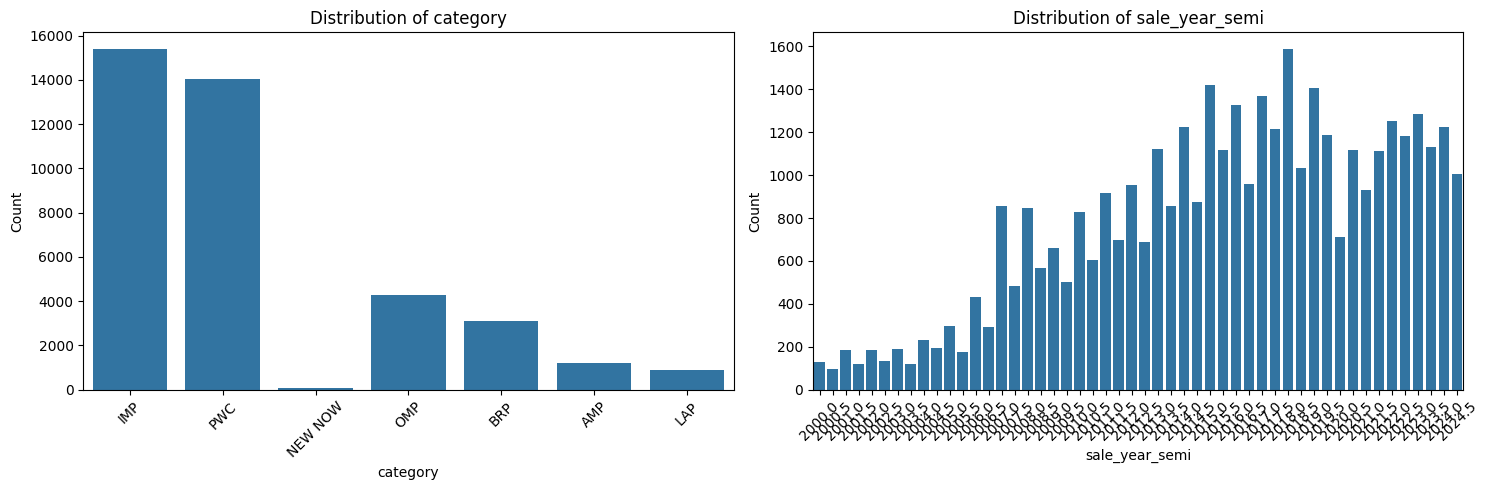

In [39]:
# List of categorical variables
categorical_columns = ['category', 'sale_year_semi'
                                      ]


print(one_hot(artwork_numeric_data, categorical_columns))

# get minimum occurence per variable
for idx, var in enumerate(categorical_columns):
  counts = artwork_numeric_data[var].value_counts()
  print(f"Minimum {var} occurence is {min(counts)}")



# visualize distribution of categorical variables
fig, axes = plt.subplots(1, len(categorical_columns), figsize=(15, 5))


for i, column in enumerate(categorical_columns):
    ax = axes[i]
    sns.countplot(x=column, data=artwork_numeric_data, ax=ax)
    ax.set_title(f'Distribution of {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=45)


plt.tight_layout()
plt.show()




**4. Data split**

In [40]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

import pandas as pd

def data_split(df):
    """
    Splits the dataset into training and testing sets based on the last semi-year.

    Parameters:
    df (pd.DataFrame): DataFrame with transaction data, including 'transaction_year_semi' and 'transaction_price'.

    Returns:
    X_train, X_test, y_train, y_test: Features and target variables for training and testing.
    """

    last_semi_year_col = df.columns[-1]  # This is typically the most recent category column after dummies

    # Split the data into training and testing sets based on the dummy columns
    train_data = df[df[last_semi_year_col] == 0]  # Train set (those where the dummy variable is 0)
    test_data = df[df[last_semi_year_col] == 1]

    # Prepare X and y for both training and testing
    X_train = train_data.drop(columns='transaction_price')
    y_train = train_data['transaction_price']
    X_test = test_data.drop(columns='transaction_price')
    y_test = test_data['transaction_price']

    # Ensure both X_train and X_test have the same columns (after dummy creation)
    X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)
    numerical_features = ['height', 'width']
    X_train, X_test = standardization(X_train, X_test, numerical_features)


    return X_train, X_test, y_train, y_test

def standardization(train, test, numerical_features):
    Train, Test = train.copy(), test.copy()
    # Apply the scaler only to the specified numerical features
    scaler = StandardScaler()
    train[numerical_features] = scaler.fit_transform(train[numerical_features])
    test[numerical_features] = scaler.transform(test[numerical_features])

    return train, test

def get_data_for_nn(data, selected_vars, dummy_vars):
  """
  Returns data in correct format for NN
  Params: data set, predictors and target, categorical variables for one-hot
          encoding (without transact)
  """
  df = data.copy()
  # select columns
  df = select_cols(df,selected_vars)
  # get single transaction format and one-hot_format
  df = repeated_to_single_transactions(df)
  df = one_hot(data, dummy_vars)
  X_train, X_test, y_train, y_test =  data_split(df)

  return torch.tensor(X_train.values, dtype=torch.float32), torch.tensor(X_test.values, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.float32),torch.tensor(y_test.values, dtype=torch.float32)





In [23]:
print(artwork_numeric_data.shape)
"""
def preprocess_title(title):
    title = title.lower()  # Convert to lowercase
    title = re.sub(r'[^\w\s]', '', title)  # Remove non-alphanumeric characters
    return title

# Apply preprocessing
artwork_numeric_data['title'] = artwork_numeric_data['title'].apply(preprocess_title)

# Handle missing values in title before applying TF-IDF
artwork_numeric_data['title'] = artwork_numeric_data['title'].fillna('')  # Fill NaNs with empty string



# Apply TF-IDF on the 'title' column
def tf_vectorizer(data):
    tfidf = TfidfVectorizer(max_df=0.9, min_df=10)
    tfidf_matrix = tfidf.fit_transform(data['title'])  # Apply TF-IDF transformation
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())

    return pd.concat([data, tfidf_df], axis=1)




artwork_numeric_data = tf_vectorizer(artwork_numeric_data)
"""


(75606, 8)


"\ndef preprocess_title(title):\n    title = title.lower()  # Convert to lowercase\n    title = re.sub(r'[^\\w\\s]', '', title)  # Remove non-alphanumeric characters\n    return title\n\n# Apply preprocessing\nartwork_numeric_data['title'] = artwork_numeric_data['title'].apply(preprocess_title)\n\n# Handle missing values in title before applying TF-IDF\nartwork_numeric_data['title'] = artwork_numeric_data['title'].fillna('')  # Fill NaNs with empty string\n\n\n\n# Apply TF-IDF on the 'title' column\ndef tf_vectorizer(data):\n    tfidf = TfidfVectorizer(max_df=0.9, min_df=10)\n    tfidf_matrix = tfidf.fit_transform(data['title'])  # Apply TF-IDF transformation\n    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())\n\n    return pd.concat([data, tfidf_df], axis=1)\n\n\n\n\nartwork_numeric_data = tf_vectorizer(artwork_numeric_data)\n"

**5. Model training**

In [36]:
class Numerical_Model(nn.Module):

    def __init__(self, in_features, h1, h2, h3,  out_features=1):
        super().__init__()
        self.fc1 = nn.Linear(in_features, h1)
        self.fc2 = nn.Linear(h1,h2)
        self.fc3 = nn.Linear(h2, h3)
        self.out = nn.Linear(h3, out_features)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.out(x)
        return x


def train(network, trainloader, epochs = 100, eta = 0.01, momentum = 0.9):
    optimizer = torch.optim.SGD(params = network.parameters(), lr = eta,
                                momentum = momentum)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    network = network.to(device)
    loss = torch.nn.MSELoss()
    for epoch in epochs:
      # train network on training data
      for x, t in trainloader:
        network.train()
        optimizer.zero_grad()
        z = network(x.to(device))
        J = loss(z, t.to(device))
        J.backward()
        optimizer.step()
      # test on validation data







